In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K

import SegDataGenerator as gen

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data_path = 'data/dataset_256x256.npz'
model_path = 'model/'
learning_rate = 0.0001
batch_size = 1
img_height = 256
img_width = 256
img_channel = 1
steps_per_epoch=5
epochs=10
validation_step=2

In [3]:
def mean_iou(y_true, y_pred):
    print("get into mean_iou")
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [4]:
class UNet():
    def __init__(self, learning_rate, batch_size, img_height, img_width, img_channel):
        self.lr = learning_rate
        self.bs = batch_size
        self.height = img_height
        self.width = img_width
        self.channel = img_channel
        self.model = self.create_model()
    
    def ConvBlock(self, x, num_filter, conv_kernel_size=(3,3), dropout=0.2,
                  pool_size=(2,2), hasPool=True):
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (x)
        conv = Dropout(dropout) (conv)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (conv)
        if hasPool == True:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        return conv
    
    def DeConvBlock(self, x, cat, num_filter=16, conv_kernel_size=(3,3), up_size=(2,2), 
                    up_stride=(2,2), dropout=0.2, axis=-1):
        deconv = Conv2DTranspose(num_filter, up_size, strides=up_stride, padding='same') (x)
        deconv = concatenate([deconv, cat], axis=axis)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (deconv)
        conv = Dropout(dropout) (conv)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                    kernel_initializer='he_normal', padding='same') (conv)
        return conv

    def create_model(self):
        inputs = Input((self.height, self.width, self.channel))
        
        # down-sampling
        conv1, pool1 = self.ConvBlock(inputs, 16, (3,3), 0.1, (2,2))
        conv2, pool2 = self.ConvBlock(pool1, 32, (3,3), 0.1, (2,2))
        conv3, pool3 = self.ConvBlock(pool2, 64, (3,3), 0.2, (2,2))
        conv4, pool4 = self.ConvBlock(pool3, 128, (3,3), 0.2, (2,2))
        conv5 = self.ConvBlock(pool4, 256, (3,3), 0.3, hasPool=False)
        
        # up-sampling
        conv6 = self.DeConvBlock(conv5, conv4, 128, (3,3), (2,2), (2,2), 0.2)
        conv7 = self.DeConvBlock(conv6, conv3, 64, (3,3), (2,2), (2,2), 0.2)
        conv8 = self.DeConvBlock(conv7, conv2, 32, (3,3), (2,2), (2,2), 0.1)
        conv9 = self.DeConvBlock(conv8, conv1, 16, (3,3), (2,2), (2,2), 0.1, axis=3)
        
        outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)
        
        model = Model(inputs=[inputs], outputs=[outputs])
        adam = optimizers.Adam(lr = self.lr)
        model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[mean_iou])
        print(model.summary())
        
        return model


In [5]:
def main(args):
    unet = UNet(learning_rate, batch_size, img_height, img_width, img_channel)
    model = unet.model
#     plot_model(model, to_file='model.png')
    print("generate model!")
    
    # define generator
    trainGenerator = gen.SegDataGenerator(validation_split=0.2)
    train_data = trainGenerator.flow_from_directory(data_path, subset='training', batch_size=batch_size,
                                                   class_mode='segmentation', color_mode='grayscale',
                                                   use_contour=False)
    val_data = trainGenerator.flow_from_directory(data_path, subset='validation', batch_size=batch_size,
                                                   class_mode='segmentation', color_mode='grayscale',
                                                   use_contour=False)
    print("data generator!")
    
#     image, seg = next(val_data)
#     print(seg.shape)
    
    # training
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    checkpoint = ModelCheckpoint(model_path+'weight.{epoch:02d}.hdf5', monitor='val_loss',
                                 mode='min', period=1)
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())
    model.fit_generator(train_data, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                        callbacks=[checkpoint], validation_data=val_data, 
                        validation_steps=validation_step, shuffle=True)

get into mean_iou
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
___________________________________________________________________________________________

Found 535 images belonging to 2 classes.
Reading from previously loaded data.
Found 134 images belonging to 2 classes.
data generator!
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5678519419150308225
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 153026560
locality {
  bus_id: 1
}
incarnation: 10031951511874784132
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"
]
Epoch 1/10
5/5 [==============================] - 2s 320ms/step - loss: 2.7613 - mean_iou: 0.1801 - val_loss: 1.3911 - val_mean_iou: 0.1943
Epoch 2/10
5/5 [==============================] - 0s 38ms/step - loss: 2.8273 - mean_iou: 0.1877 - val_loss: 0.7756 - val_mean_iou: 0.1524
Epoch 3/10
5/5 [==============================] - 0s 38ms/step - loss: 3.5167 - mean_iou: 0.1354 - val_loss: 0.8889 - val_mean_iou: 0.1235
Epoch 4/10
5/5 [==============================] - 0s 38ms/step - loss: 2.6120 - mean_iou: 0.1255 - val_loss: 0.7625 - val_mean_iou: 0.114

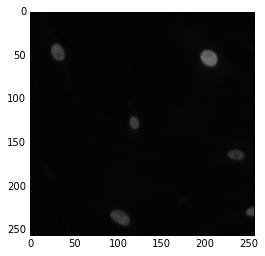

In [6]:
if __name__ == '__main__':
    main(sys.argv)